In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
print(tf.__version__)
tf.config.list_physical_devices('GPU')
print(tf.test.is_gpu_available())

2.5.0
True


In [20]:
train_img = pd.read_csv('dataset/train/images.csv',header = None)
train_label = pd.read_csv('dataset/train/labels.csv',header = None)
val_img = pd.read_csv('dataset/validation/images.csv',header = None)
val_label = pd.read_csv('dataset/validation/labels.csv',header = None)

In [21]:
train_img.head()

,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,...,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,...,0.639216,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,...,0.639216,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412


In [22]:
print(train_img.shape)
print(train_label.shape)
print(val_img.shape)
print(val_label.shape)

(3200, 8192)
(3200, 4)
(800, 8192)
(800, 4)


In [23]:
train_img = train_img.values.reshape(3200,64,128,1)
y_train = train_label.values
val_img = val_img.values.reshape(800,64,128,1)
y_val = val_label.values

In [24]:
y_train[0:5]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [25]:
y_val[0:5]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

D:\Anaconda\envs\tf_cuda_compat\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


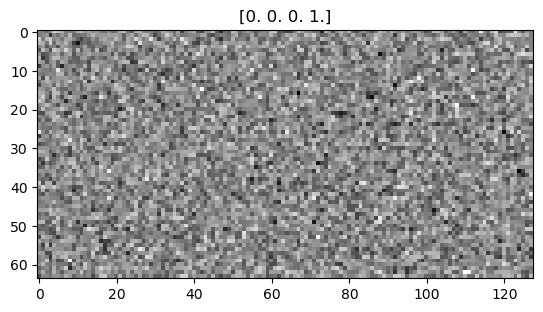

In [26]:
idx = np.random.randint(0,train_img.shape[0])
plt.imshow(np.squeeze(train_img[idx]),cmap = 'binary')
plt.title(y_train[idx])
plt.show()

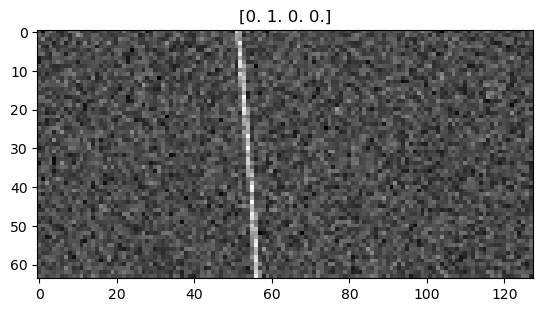

In [27]:
idx = np.random.randint(0,val_img.shape[0])
plt.imshow(np.squeeze(val_img[idx]),cmap = 'binary')
plt.title(y_val[idx])
plt.show()

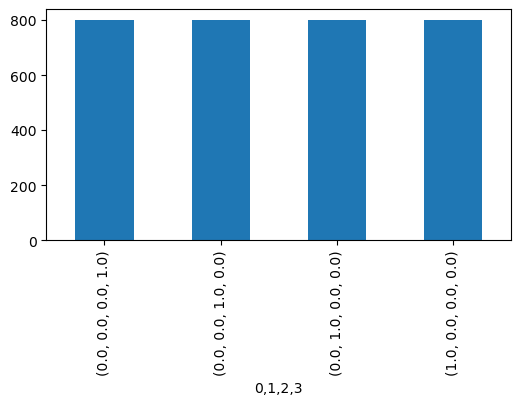

In [28]:
# Balanced dataset
train_label.value_counts().plot.bar(figsize = (6,3))
plt.show()

In [48]:
# Hyperparameters
input_shape = [64,128]
epoch = 50
lr = 1e-4
batch_size = 32

In [30]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip = True)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator()
train_gen.fit(train_img)
val_gen.fit(val_img)

In [31]:
train_ds = train_gen.flow(train_img,
                          y = y_train,
                          batch_size = batch_size,
                          shuffle = True)
val_ds = val_gen.flow(val_img,
                      y = y_val,
                      batch_size = batch_size,
                      shuffle = True)

In [32]:
len(train_ds)

100

In [44]:
vgg = VGG16(include_top = False,weights = 'imagenet')
for i in range(len(vgg.layers)):
    vgg.layers[i].trainable = False
# vgg.layers[-2].trainable = True
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [45]:
new_input_layer = tf.keras.layers.Input(shape = input_shape + [1])
new_conv_layer = tf.keras.layers.Conv2D(3,3,padding = 'same')(new_input_layer)
vgg_output = vgg(new_conv_layer)
x = tf.keras.layers.Flatten()(vgg_output)
x = tf.keras.layers.Dense(units = 128,activation = 'relu')(x)
x = tf.keras.layers.Dense(32,activation = 'relu')(x)
new_output_layer = tf.keras.layers.Dense(4,activation = 'sigmoid')(x)
model = tf.keras.Model(inputs = new_input_layer,outputs = new_output_layer)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 64, 128, 1)]      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 128, 3)        30        
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               524416    
_________________________________________________________________
dense_7 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 132 

In [47]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                            min_delta = 0.0005,
                                            patience = 5,
                                            verbose = 1)
model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = lr),
              metrics = ['accuracy'])

In [49]:
history = model.fit(train_ds,
          epochs = epoch, 
          batch_size = batch_size,
          validation_data = val_ds,
          steps_per_epoch = len(train_ds),
          validation_steps = len(val_ds),
          callbacks = [callback],
          validation_batch_size = batch_size)

Epoch 1/50
100/100 [==============================] - 15s 140ms/step - loss: 0.5721 - accuracy: 0.3316 - val_loss: 0.5467 - val_accuracy: 0.3000
Epoch 2/50
100/100 [==============================] - 14s 138ms/step - loss: 0.5250 - accuracy: 0.4994 - val_loss: 0.5014 - val_accuracy: 0.5200
Epoch 3/50
100/100 [==============================] - 14s 138ms/step - loss: 0.4748 - accuracy: 0.6559 - val_loss: 0.4471 - val_accuracy: 0.6925
Epoch 4/50
100/100 [==============================] - 14s 139ms/step - loss: 0.4218 - accuracy: 0.7066 - val_loss: 0.3980 - val_accuracy: 0.7113
Epoch 5/50
100/100 [==============================] - 14s 140ms/step - loss: 0.3792 - accuracy: 0.7113 - val_loss: 0.3623 - val_accuracy: 0.7188
Epoch 6/50
100/100 [==============================] - 14s 142ms/step - loss: 0.3491 - accuracy: 0.7163 - val_loss: 0.3365 - val_accuracy: 0.7250
Epoch 7/50
100/100 [==============================] - 14s 143ms/step - loss: 0.3226 - accuracy: 0.7253 - val_loss: 0.3111 - val_ac